# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [5]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 2

sanity checks for our good ole adjoint

In [3]:
propertynames(sys)

(:H, :G, :n_drives, :levels, :params)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

In [6]:
Random.seed!(5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
solve!(def, max_iter=250, print_level=5)

#Adjoint
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem(
    H_drive,
    [∂ₑHₐ]
)

# Multiplicative error template
# H = aX
# H_drive_m = a -> a[1] * H_drive
# H_vars_array = Function[H_drive_m]

varsys_mult = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X],
    2
)

varsys_both = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
    2
)

varadd_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        robust_times=[[T]],
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )
solve!(varadd_prob, max_iter=250, print_level=5)

varmult_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        robust_times=[[T]],
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )
solve!(varmult_prob, max_iter=250, print_level=5)

varboth_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        robust_times=[[T]],
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )
solve!(varboth_prob, max_iter=250, print_level=5)

#Toggling

Hₑ_add = a -> PAULIS.X
add_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
    )
solve!(add_prob, max_iter=250, print_level=5)

X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

mult_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_mult;
    piccolo_options=piccolo_opts
    )
solve!(mult_prob, max_iter=250, print_level=5)


Hₑ_both = a -> PAULIS.X + a[1] * X_drive
both_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_both;
    piccolo_options=piccolo_opts
    )
solve!(both_prob, max_iter=250, print_level=5)



    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4362
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      588
                     variables with only lower bounds:        0
                variables with 

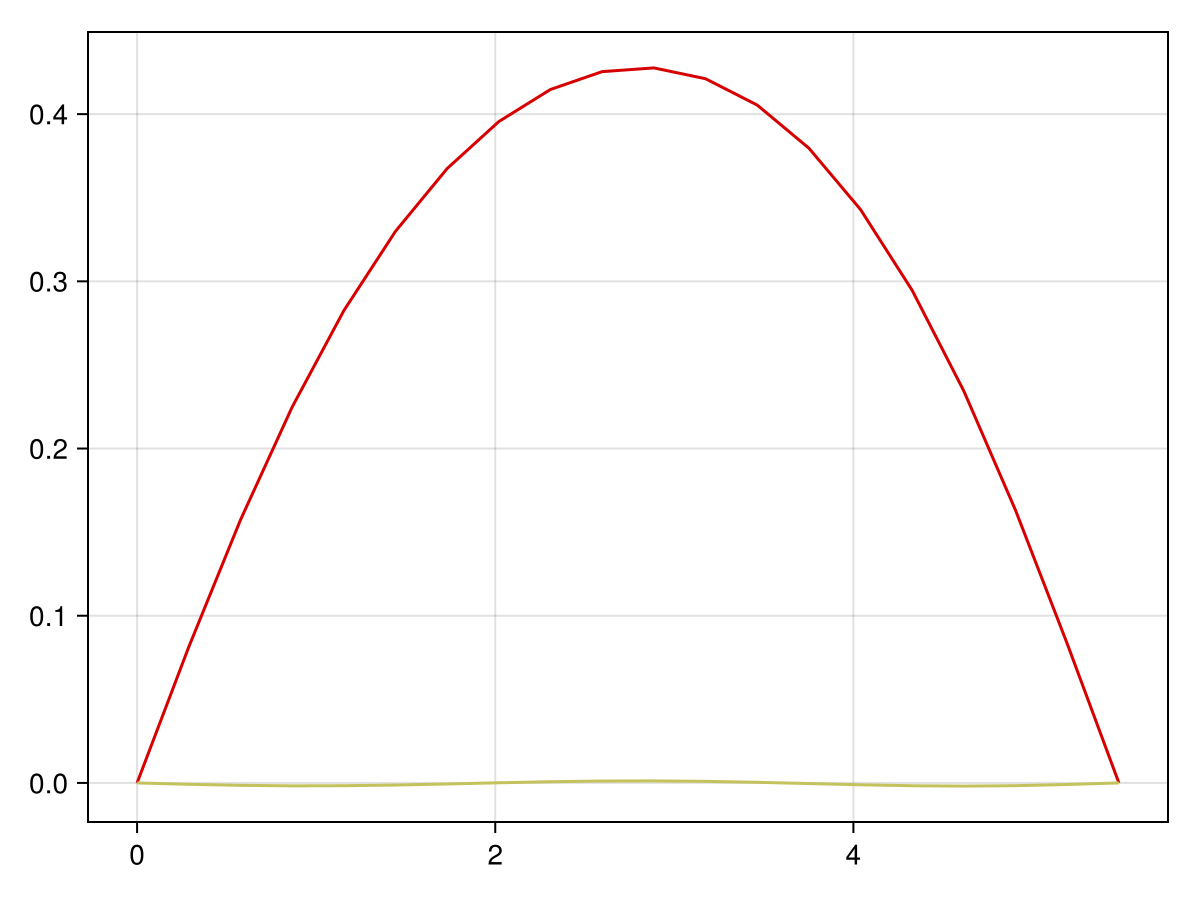

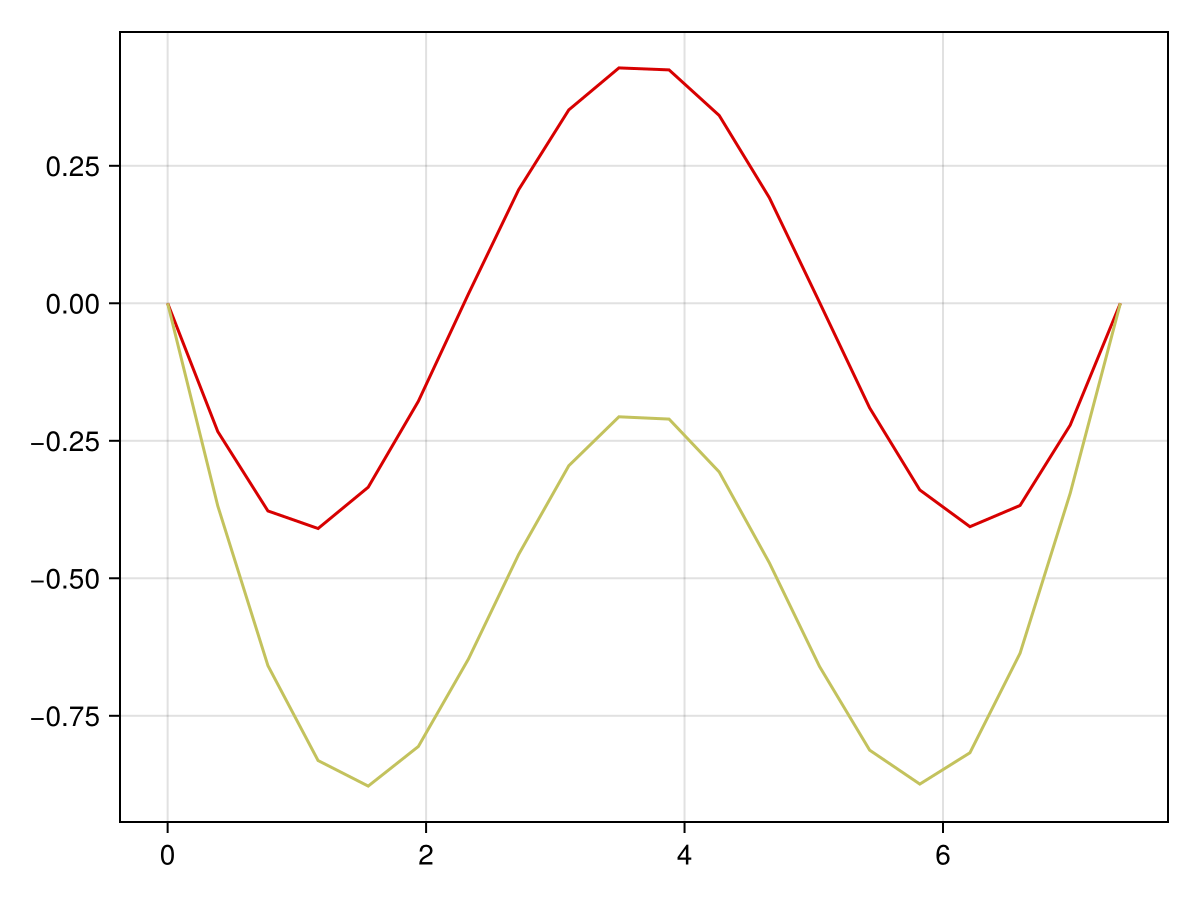

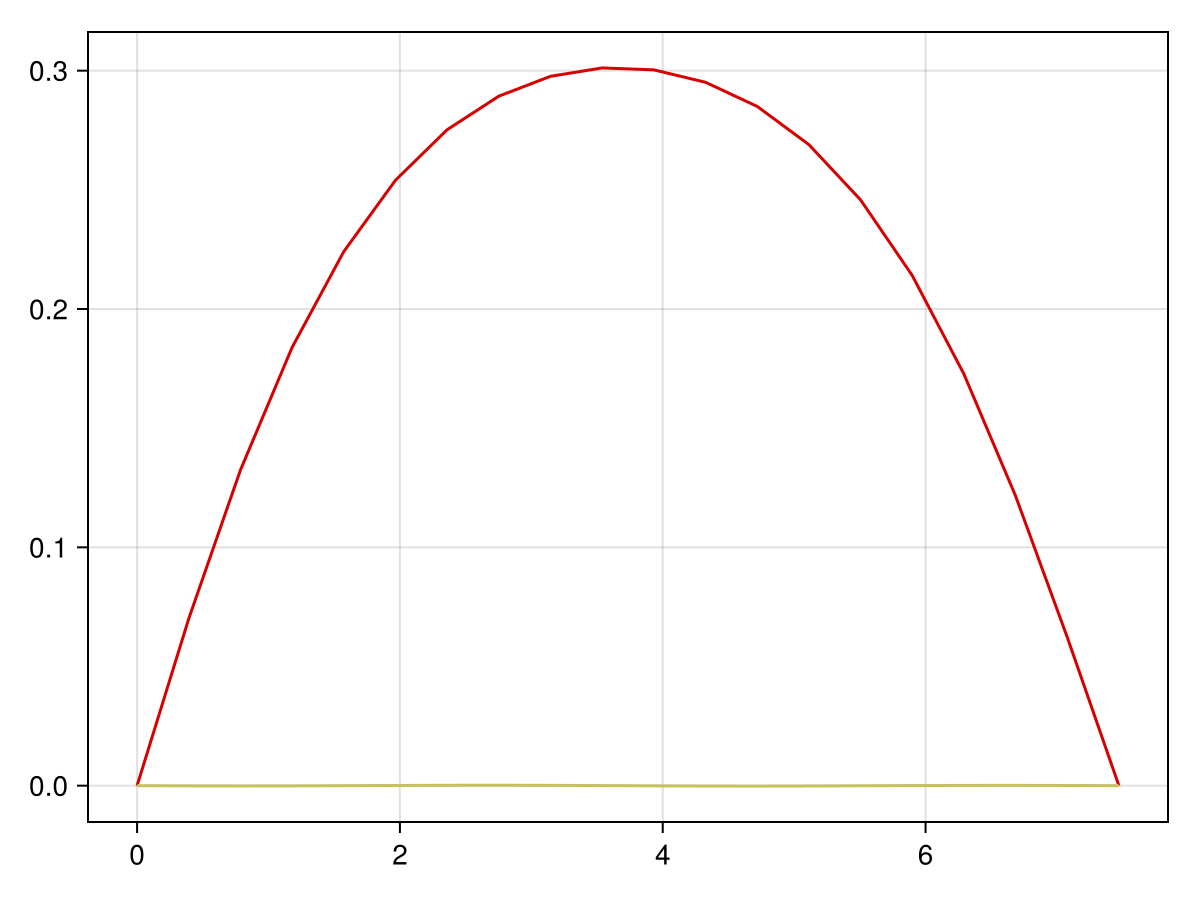

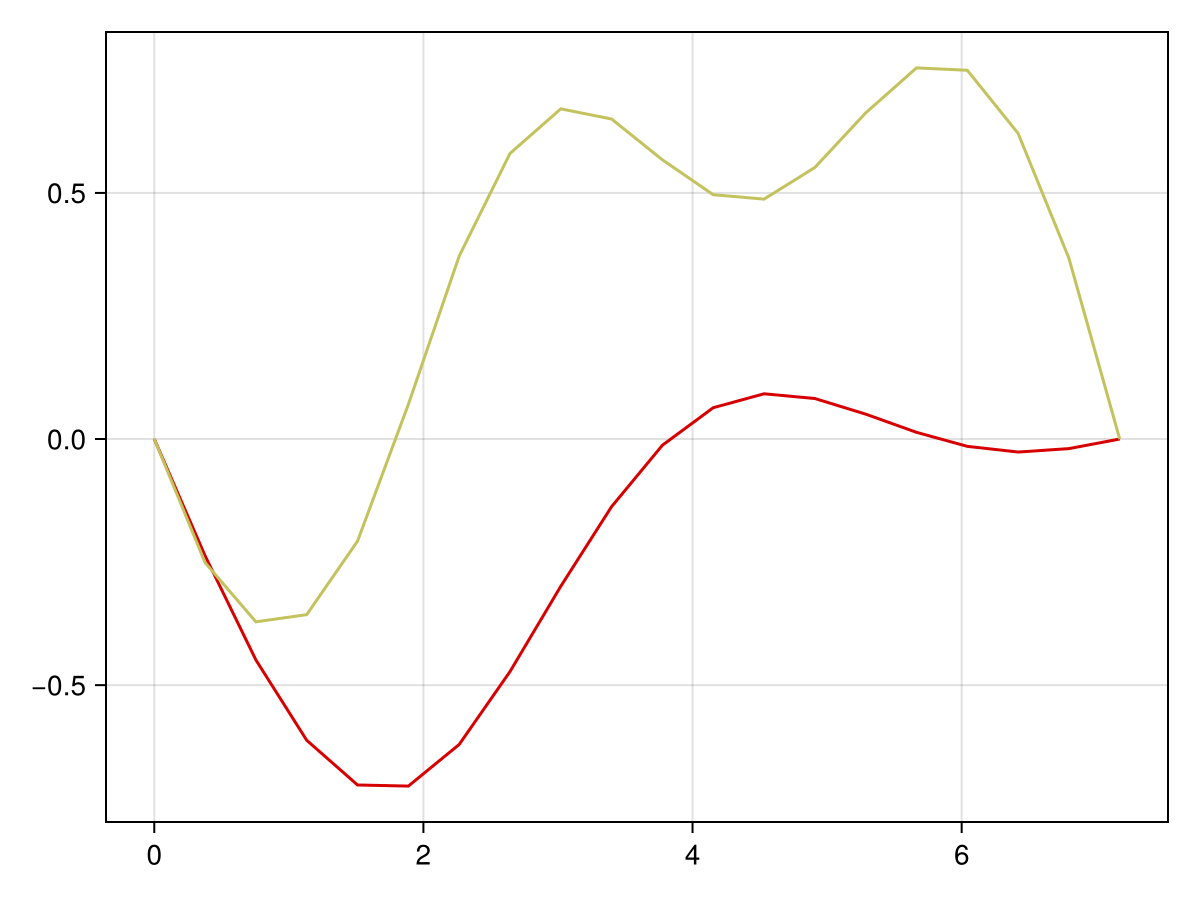

CairoMakie.Screen{IMAGE}


In [4]:
display(CairoMakie.plot(def.trajectory, :a))
display(CairoMakie.plot(add_prob.trajectory, :a))
display(CairoMakie.plot(mult_prob.trajectory, :a))
display(CairoMakie.plot(both_prob.trajectory, :a))

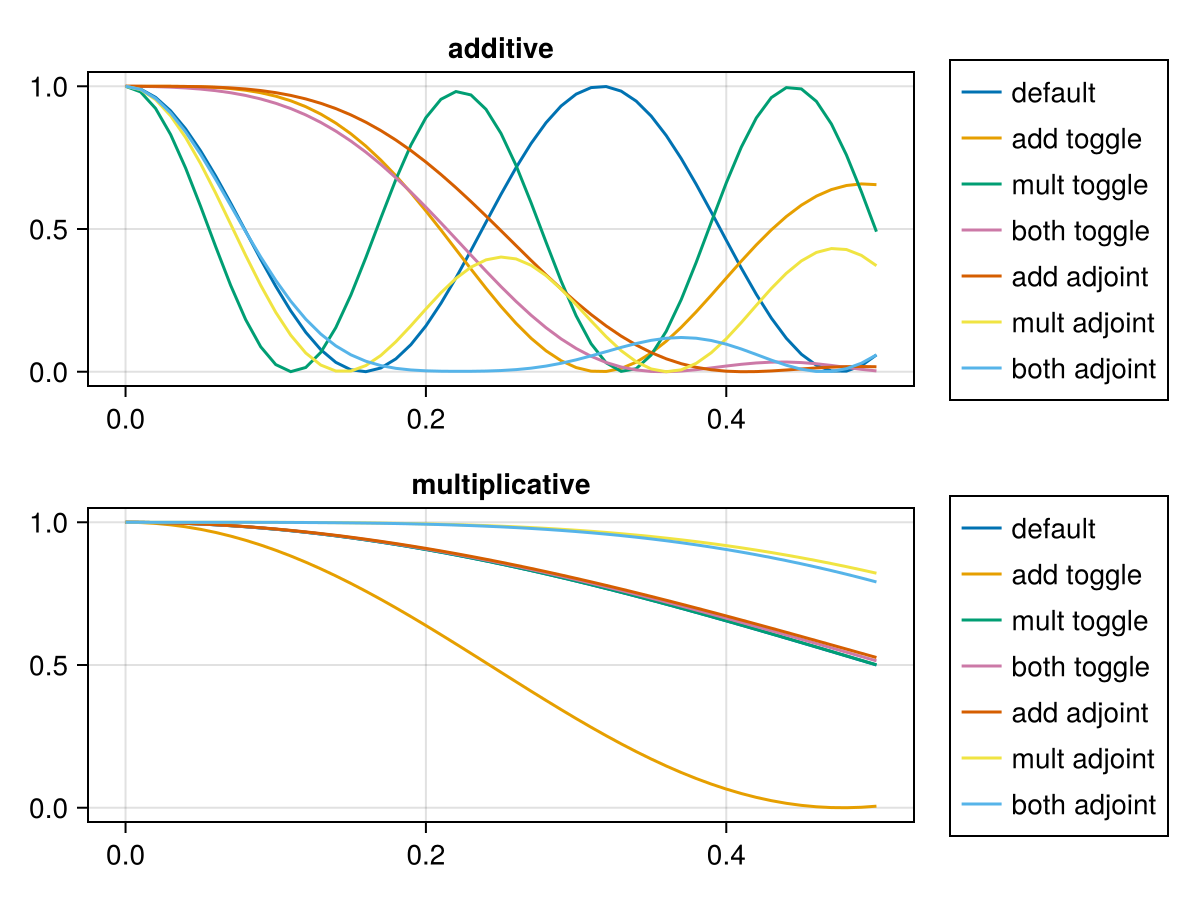

In [7]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="mult toggle", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="mult toggle", color=colors[3], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# adjoint obj

# (add)
ys = [unitary_rollout_fidelity(varadd_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

ys = [unitary_rollout_fidelity(varadd_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="both adjoint", color=colors[5], linestyle=:solid)

ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="both adjoint", color=colors[5], linestyle=:solid)


Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f
